# Neutral Region Analysis

A reviewer asked that we analyse the neutral regions, since they are the majority. 

## extract the neutral regions

In [1]:
# r kernel
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(DESeq2))

In [2]:
load("../../data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/res.Rdata")

In [3]:
#convert to df
res_df <- as.data.frame(res)

In [4]:
#select bins that have padj > 0.1
neutral_bins <- filter(res_df, padj > 0.1)

In [5]:
cts_col_names <- c("Bin_ID", "Chr", "Start", "End", "Strand", "Length", "DNA1", "DNA2", "DNA3", "RNA1", "RNA2", "RNA3")

cts_df <- read_tsv("../../data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/cts.tsv",
                   col_names = cts_col_names, skip = 2)

Rows: 6209807 Columns: 12

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Bin_ID, Chr, Strand
dbl (9): Start, End, Length, DNA1, DNA2, DNA3, RNA1, RNA2, RNA3


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [6]:
#format to bed
neutral_bins_bed <- rownames_to_column(neutral_bins, var = "Bin_ID") %>% left_join(cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
    dplyr::mutate(Start = Start - 1) %>%
    dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
    dplyr::arrange(Chr, Start, End)

In [7]:
write_tsv(neutral_bins_bed, "../../data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/neutral_bins.bed", col_names = FALSE)

## Convert to merged regions

In [1]:
# python kernel
import os
import pandas as pd
import sys
import pybedtools

#function remade for neutral
def merge_bins(out_dir):
    
    #make bedtool objects for each. 
    neutral = pybedtools.BedTool(os.path.join(out_dir,"neutral_bins.bed"))

    #merge each and isolate the average log2FC score. Sort by position.  
    neutral_regions = neutral.merge(c=5, o="mean").sort()

    #convert to pandas df. 
    neutral_regions_df = pd.read_table(neutral_regions.fn, names=['Chr', 'Start', 'End', 'Score'])

    #add a name column
    #Add the index plus 1 (so it is starting at 1 vs 0) to a region_ string. 
    neutral_regions_df['Name'] = "region_" + (neutral_regions_df.index + 1).astype(str)

    #add a strand column 
    neutral_regions_df['Strand'] = "."

    #rearrange column order
    neutral_regions_df = neutral_regions_df[['Chr', 'Start', 'End', 'Name', 'Score', 'Strand']]

    # Write to out_dir. 
    neutral_regions_df.to_csv(os.path.join(out_dir, "neutral_regions.bed"), sep='\t', header=False, index = False)
    
#execute function
merge_bins(out_dir = "../../data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink")

## Annotate

### ChIPSeeker

In [1]:
library(tidyverse)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)

data_dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR"

neutral <- annotatePeak(paste0(data_dir, "/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/neutral_regions.bed"), 
                       tssRegion = c(-2000, 1000), TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, 
                       annoDb = "org.Hs.eg.db", flankDistance = 5000)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()



ChIPseeker v1.30.0  For help: https://guangchuangyu.github.io/software/ChIPseeker

If you use ChIPseeker in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Qing-Yu He. ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization. Bioinformatics 2015, 31(14):2382-2383

Loading required package: GenomicFeatures

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked 

>> loading peak file...				 2022-06-01 01:30:31 PM 
>> preparing features information...		 2022-06-01 01:30:54 PM 
>> identifying nearest features...		 2022-06-01 01:31:20 PM 
>> calculating distance from peak to TSS...	 2022-06-01 01:31:24 PM 
>> assigning genomic annotation...		 2022-06-01 01:31:24 PM 
>> adding gene annotation...			 2022-06-01 01:32:42 PM 


Loading required package: org.Hs.eg.db



'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-06-01 01:32:53 PM 
>> done...					 2022-06-01 01:32:53 PM 


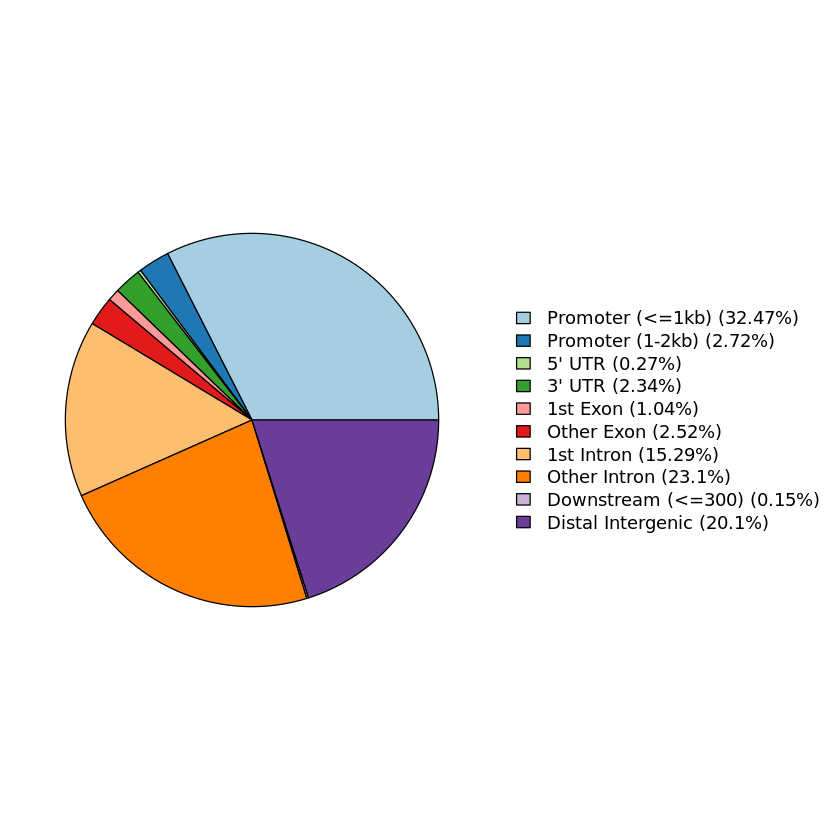

In [7]:
plotAnnoPie(neutral)

In [9]:
res <- '/data/hodges_lab/ATAC-STARR_B-cells/results/GR_revisions'
pdf(file = paste0(res, "/regulatory-regions_TSS-annotation_neutral-pie.pdf"), width = 8, height = 4)
plotAnnoPie(neutral)
dev.off()

png 
  2

### Functional Annotation by ChromHMM

In [1]:
# bash kernel

CHMM_DIR='/data/hodges_lab/public_data/GM12878/obtained_as_processed_files'
AS_DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink'

#Output
OUTPUT_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/AS-regions_chromHMM-assignment'

#neutral
bedtools intersect -u -a ${CHMM_DIR}/GM12878_ChromHMM_18-state_E116_18_core_K27ac_hg38lift_mnemonics.bed \
    -b ${AS_DIR}/neutral_regions.bed > ${OUTPUT_DIR}/GM12878inGM12878_neutral_0.1padj_50-bin_ChromHMM.bed


Rows: 159603 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Chr, Chrom_HMM_State
dbl (2): Start, End


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



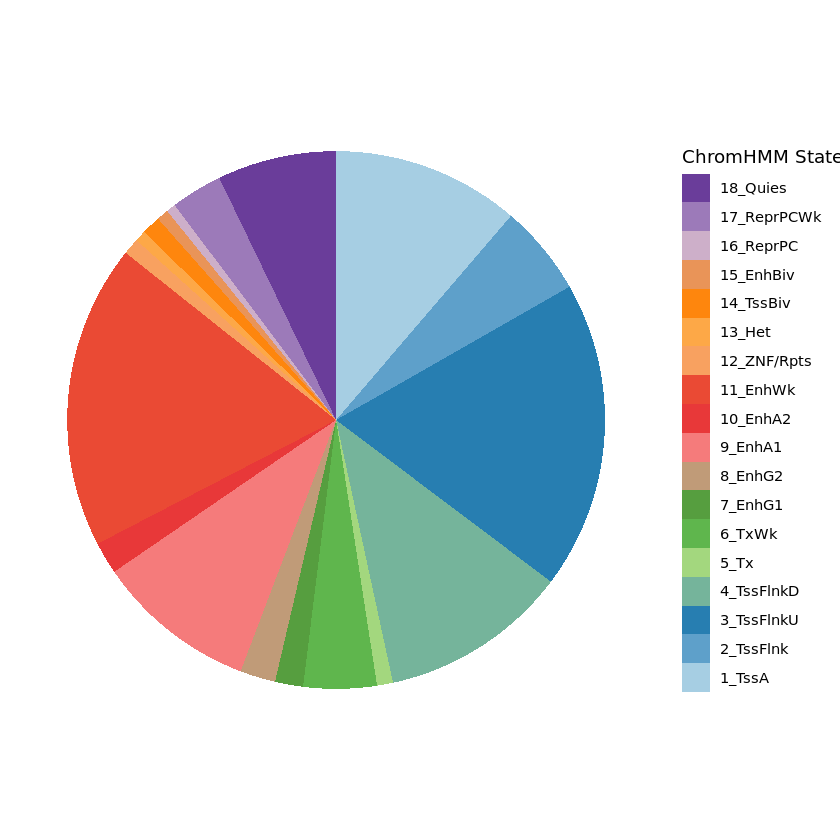

In [16]:
# R kernel
library(tidyverse)
library(ggrepel)
library(RColorBrewer)
library(pals)

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/AS-regions_chromHMM-assignment'

#Read_tsvs

neutral <- read_tsv(paste0(dir, "/GM12878inGM12878_neutral_0.1padj_50-bin_ChromHMM.bed"), 
    col_names = c("Chr", "Start", "End", "Chrom_HMM_State")) %>% mutate(Type="neutral regions")

#wrangle tsvs
tsv_tally <- group_by(neutral, Chrom_HMM_State, Type) %>% tally()
tsv_tally$Chrom_HMM_State <- factor(tsv_tally$Chrom_HMM_State, 
                                    levels = c("1_TssA", "2_TssFlnk", "3_TssFlnkU", "4_TssFlnkD", 
                                               "5_Tx", "6_TxWk", "7_EnhG1", "8_EnhG2", "9_EnhA1", 
                                               "10_EnhA2", "11_EnhWk", "12_ZNF/Rpts", "13_Het", 
                                               "14_TssBiv", "15_EnhBiv", "16_ReprPC", "17_ReprPCWk", 
                                               "18_Quies")) %>% fct_rev()

#define color palette
nb.cols <- 18
mycolors <- colorRampPalette(rev(brewer.pal(10, "Paired")))(nb.cols) 

pie <- ggplot(tsv_tally, aes(y = Type, x = n, fill = Chrom_HMM_State)) + 
  geom_bar(width = 1, stat = "identity", size = 0, position = "fill", color = "white") +
  coord_polar("x", start=0) +
  scale_fill_manual(values = mycolors) +
  labs(fill="ChromHMM State") +
  theme_void()

pie

In [18]:
res <- '/data/hodges_lab/ATAC-STARR_B-cells/results/GR_revisions'
ggsave(pie, filename = paste0(res, "/regulatory-regions_ChromHMM-annotation_pie.pdf"), device = cairo_pdf, width = 4, height = 6)